# Начало

В этой работе будут разобраны такие аспекты NLP как:
* Simple RNN's
* Word Embeddings
* LSTM's
* GRU's
* BI-Directional RNN's
* Encoder-Decoder Models (Seq2Seq Models)
* Attention Models
* Transformers
* BERT

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Input, LSTM, Dense, Embedding, Attention
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Подключение к TPU, для ускоренной работы, в частности с BERT

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
train = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
validation = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [6]:
train[train['toxic']==1][:10]

,id,comment_text,toxic
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
44,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,1
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1
56,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1
58,0021fe88bc4da3e6,My Band Page's deletion. You thought I was gon...,1


In [7]:
train.shape

(223549, 3)

In [8]:
train = train.loc[:4000,:]
train.shape

(4001, 3)

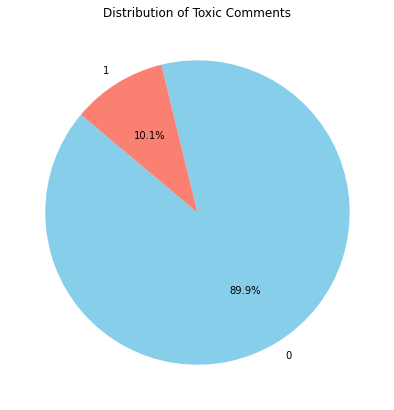

In [9]:
toxic_counts = train['toxic'].value_counts()

# Создадим круговую диаграмму
plt.figure(figsize=(7, 7))
plt.pie(toxic_counts, labels=toxic_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])
plt.title('Distribution of Toxic Comments')
plt.show()

In [10]:
train['comment_text'].apply(lambda x:len(str(x).split())).max()

1087

In [11]:
def roc_auc(predictions,target):
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

### Разделение данных

In [12]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

# RNN

RNN (Recurrent Neural Network) – это класс нейронных сетей, специально разработанный для работы с последовательными данных, где вход и/или вывод зависят от предыдущих шагов или контекста. Вот основные пункты, описывающие RNN:

1. **Структура RNN**:
   - RNN состоит из набора одинаковых нейронов (или "ячеек") с обратными связями. Эти нейроны принимают входные данные и предыдущее состояние (предыдущий вывод) как вход, чтобы учитывать контекст при обработке нового входа.

2. **Обратные связи**:
   - Основное отличие RNN от обычных нейронных сетей состоит в наличии обратных связей. Это позволяет RNN использовать информацию из предыдущих выходов для поддержания внутреннего состояния (памяти), что делает его подходящим для работы с последовательными данных.

3. **Последовательные данные**:
   - RNN хорошо подходит для работы с различными типами последовательных данных, такими как тексты, временные ряды, аудио и видео последовательности. Он может моделировать зависимости между элементами последовательности благодаря своей способности к запоминанию контекста.

4. **Архитектура**:
   - Обычная архитектура RNN включает в себя несколько временных шагов (или "слоев"), где каждый шаг принимает входные данные и предыдущее состояние. Это создает цепочку обработки данных, где каждый следующий шаг зависит от предыдущего.

5. **Проблема затухающих и взрывающихся градиентов**:
   - У RNN есть проблема с затухающими и взрывающимися градиентами из-за многократного умножения градиентов на матрицу весов во времени. Это может привести к тому, что градиенты становятся очень маленькими или очень большими, что затрудняет обучение модели на длинных последовательностях.

6. **Варианты RNN**:
   - Существуют различные варианты RNN, такие как LSTM (Long Short-Term Memory) и GRU (Gated Recurrent Unit), которые были разработаны для решения проблемы затухающих градиентов и улучшения способности модели к запоминанию долгосрочных зависимостей в последовательных данных.

7. **Применение RNN**:
   - RNN применяются во многих областях, таких как машинный перевод, генерация текста, распознавание речи, анализ временных рядов, автоматическое завершение текста и другие задачи, где последовательные данные играют важную роль.

In [13]:
token = text.Tokenizer(num_words=None)
max_len = 1100

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [14]:
xtrain[0]

"With respect, you seem to be mistaking references found in some online media sources to usage in a whole country. Getting off the subject a little, but it does have some relevance, the NZ Herald routinely refers to NZ'ers of European descent as 'Pakeha', where as there are plenty who find this pejorative and insulating .. although this attitude is softening. Of course I would not include this in any article (and defintely not this one) without suitable reference lest it be deemed original research, I note it here as an example that the language of the media does not necessarily fully represent that of a country.\nWhat is very important to note is the skewed statistics of quoting the number of 'hits' for rooster found in NZ media. Many of these hits will be refering to the Australian league club Sydney Roosters and not the poultry. Clearly rugby is of very considerable greater interest to the country's readership than poultry.\nJust stating both 'Cockerel' and 'Rooster' are used is fac

In [15]:
word_index['with']

21

In [16]:
print(xtrain_seq[0])
xtrain_pad[0]

[21, 1002, 6, 380, 2, 16, 7074, 243, 328, 10, 57, 833, 507, 100, 2, 1181, 10, 4, 514, 485, 416, 226, 1, 237, 4, 227, 26, 11, 112, 18, 57, 4575, 1, 4576, 7075, 5486, 1039, 2, 10538, 3, 891, 3473, 17, 10539, 128, 17, 40, 19, 1481, 65, 139, 13, 7076, 5, 10540, 411, 13, 1638, 8, 10541, 3, 394, 7, 45, 15, 420, 13, 10, 53, 24, 5, 10542, 15, 13, 48, 169, 1553, 248, 7077, 11, 16, 4577, 267, 365, 7, 178, 11, 61, 17, 30, 261, 9, 1, 359, 3, 1, 507, 112, 15, 2363, 1482, 3120, 9, 3, 4, 485, 38, 8, 113, 381, 2, 178, 8, 1, 10543, 1428, 3, 2194, 1, 305, 3, 10544, 12, 10545, 328, 10, 4576, 507, 149, 3, 133, 1369, 47, 16, 4578, 2, 1, 2195, 793, 1105, 4579, 10546, 5, 15, 1, 7078, 315, 10547, 8, 3, 113, 5487, 1639, 421, 2, 1, 5488, 7079, 93, 7078, 49, 1318, 191, 7080, 5, 7081, 19, 121, 8, 794, 3474, 1730, 2, 2595, 2364, 1181, 8, 10548, 14, 10549, 1224, 5, 1224, 9, 8, 4580, 864, 30, 2365, 237, 67, 7, 42, 58, 44, 1370, 2, 1, 24, 10, 244, 2, 10550, 2364, 1181, 91, 191, 7080, 25, 7081, 19, 515]


array([   0,    0,    0, ..., 7081,   19,  515], dtype=int32)

In [17]:
%%time
with strategy.scope():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1100, 300)         6752400   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               40100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 6,792,601
Trainable params: 6,792,601
Non-trainable params: 0
_________________________________________________________________
CPU times: user 698 ms, sys: 635 ms, total: 1.33 s
Wall time: 2.97 s


In [18]:
model.fit(xtrain_pad, ytrain, epochs=3, batch_size=128*strategy.num_replicas_in_sync) #Multiplying by Strategy to run on TPU's

Epoch 1/3
25/25 [==============================] - 20s 706ms/step - loss: 0.3627 - accuracy: 0.8866
Epoch 2/3
25/25 [==============================] - 17s 697ms/step - loss: 0.3017 - accuracy: 0.8994
Epoch 3/3
25/25 [==============================] - 18s 707ms/step - loss: 0.2100 - accuracy: 0.9197


In [19]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.74%


In [20]:
scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': roc_auc(scores,yvalid)})

# Word Embeddings

Word Embeddings (векторные представления слов) - это техника в машинном обучении, которая позволяет представлять слова в виде плотных векторов в многомерном пространстве, где семантически близкие слова имеют близкие векторные представления

1. **Понятие Word Embeddings**:
   - Word Embeddings представляют слова в виде векторов фиксированной размерности. Каждое слово в словаре ассоциируется с уникальным вектором, который характеризует его семантический смысл.

2. **Зачем нужны Word Embeddings**:
   - Векторные представления слов позволяют модели машинного обучения улавливать семантические и синтаксические отношения между словами на основе их контекста. Это позволяет улучшить производительность модели в задачах обработки естественного языка (NLP).

3. **Методы создания Word Embeddings**:
   - **Word2Vec**: Один из наиболее распространенных методов, который обучает нейронные сети предсказывать соседние слова для данного слова в тексте. Результатом обучения являются плотные векторные представления слов.
   - **GloVe (Global Vectors for Word Representation)**: Этот метод использует статистику совместной встречаемости слов в корпусе текстов для построения векторных представлений.
   - **FastText**: Метод, расширяющий идеи Word2Vec путем учета морфологической структуры слов.

4. **Семантические отношения**:
   - Векторы, полученные с помощью Word Embeddings, зачастую демонстрируют интересные свойства, такие как аналогии между словами. Например, вектор разности между векторами слов "король" и "мужчина", плюс вектор слова "женщина", приблизительно равен вектору слова "королева".

5. **Применение Word Embeddings**:
   - Word Embeddings используются в различных задачах обработки естественного языка (NLP), таких как машинный перевод, классификация текстов, анализ тональности, автозаполнение текста и другие.

6. **Использование в нейронных сетях**:
   - Векторные представления слов часто используются в качестве входных данных для нейронных сетей в задачах обработки текстов. Например, в слое `Embedding` нейронной сети, где слова представляются векторами из предварительно обученных Word Embeddings или обучаются вместе с моделью на задачу конкретной задачи.

7. **Пример использования в задаче**:
   - В вашем примере использование `Embedding` слоя в RNN позволяет представить каждое слово из текста в виде плотного вектора перед подачей его на вход RNN. Это позволяет модели учитывать семантические отношения между словами при анализе текстовых данных.

Word Embeddings являются мощным инструментом в области NLP, который позволяет сетям улавливать и использовать семантическую информацию о словах для решения различных задач.

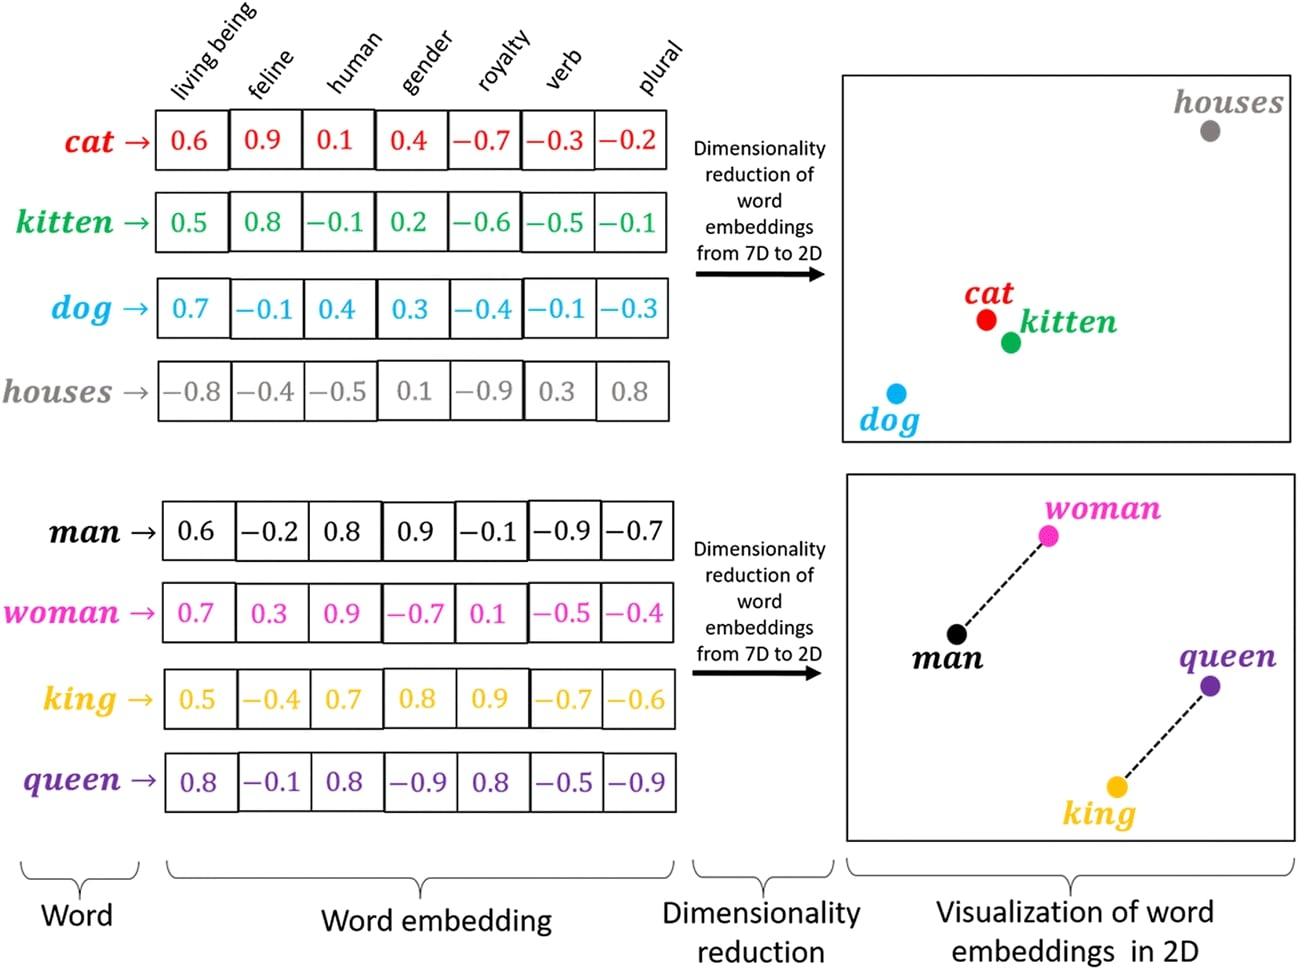

In [21]:
embeddings_index = {}
f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [05:23, 6790.09it/s]

Found 2196017 word vectors.


# LSTM

LSTM (Long Short-Term Memory) - это особый тип рекуррентной нейронной сети (RNN), который специально разработан для работы с последовательными данных, позволяя более эффективно учитывать долгосрочные зависимости в данных и бороться с проблемой затухающих градиентов. Давайте рассмотрим LSTM подробнее:

1. **Структура LSTM**:
   - LSTM состоит из повторяющихся блоков (ячеек LSTM), каждый из которых имеет специальную структуру, позволяющую сохранять и использовать информацию на протяжении многих временных шагов.

2. **Основные компоненты LSTM**:
   - **Cell State (Состояние ячейки)**: Это внутреннее состояние ячейки LSTM, которое передается и изменяется в ходе времени. Оно может содержать информацию о долгосрочных зависимостях в данных.
   - **Hidden State (Скрытое состояние)**: Это состояние, которое выходит из ячейки LSTM и передается на следующий временной шаг или другие слои сети. Оно может содержать информацию о текущем состоянии входных данных.

3. **Работа LSTM на каждом временном шаге**:
   - На каждом временном шаге LSTM принимает на вход текущий входной вектор (например, векторное представление слова) и скрытое состояние с предыдущего временного шага.
   - Используя входной вектор и предыдущее скрытое состояние, LSTM принимает решение о том, как обновить свои внутренние состояния (ячейку и скрытое состояние) и какое значение передать на следующий временной шаг.

4. **Преимущества LSTM**:
   - **Долгосрочные зависимости**: LSTM способна сохранять информацию на протяжении многих временных шагов благодаря механизму контроля потока информации через ячейку.
   - **Решение проблемы затухающих градиентов**: LSTM использует специальную архитектуру с воротами (гейтами), которая помогает контролировать поток градиентов и избегать их исчезновения или взрыва во время обучения.

5. **Компоненты LSTM ячейки**:
   - **Input Gate (Входной гейт)**: Решает, какая информация должна быть обновлена в ячейке.
   - **Forget Gate (Гейт забывания)**: Решает, какая информация следует забыть из предыдущего состояния ячейки.
   - **Output Gate (Выходной гейт)**: Решает, какая информация должна быть выведена из ячейки как скрытое состояние.

6. **Применение LSTM**:
   - LSTM широко используется в задачах обработки естественного языка (NLP), таких как машинный перевод, генерация текста, анализ тональности, моделирование последовательностей и другие задачи, где важны долгосрочные зависимости в данных.

7. **Пример использования LSTM**:
   - В контексте нашего кода, замена `SimpleRNN` на `LSTM` позволит модели лучше учитывать долгосрочные зависимости между словами в тексте при решении задачи бинарной классификации. LSTM будет более эффективно сохранять информацию о контексте и использовать ее для принятия решений о классификации текстовых данных.

In [22]:
list(embeddings_index.items())[20567]

('comforts',
 array([ 0.79984  , -0.18054  ,  0.11904  , -0.66658  , -0.12605  ,
        -0.03173  ,  0.29402  , -0.20393  , -0.73133  ,  1.7598   ,
         0.61112  , -0.71021  , -0.52336  ,  0.24878  , -0.054708 ,
        -0.39074  , -0.21389  ,  0.38944  ,  0.38217  ,  0.61767  ,
        -1.1366   ,  0.02257  ,  0.47778  ,  0.19249  , -0.10875  ,
        -0.074195 ,  0.18755  , -0.18421  , -0.37137  ,  0.076989 ,
         0.15058  , -0.090127 , -0.73419  ,  0.13042  ,  0.28228  ,
        -0.03217  , -0.16372  , -0.15035  , -0.20807  ,  0.52755  ,
        -0.058976 , -0.29836  ,  0.12323  ,  0.41567  , -0.20039  ,
         0.60368  , -0.0056153,  0.14966  ,  0.11498  ,  0.31598  ,
        -0.36677  , -0.3381   ,  0.032607 , -0.071827 , -0.51504  ,
        -0.0096694,  0.15171  ,  0.10594  , -0.11982  ,  0.4894   ,
         0.91577  ,  0.19963  ,  0.47376  , -0.23082  , -0.15816  ,
         0.42312  ,  0.3032   ,  0.31715  ,  0.08979  , -0.31878  ,
         0.043984 , -0.0091824, -0.

In [23]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 22507/22507 [00:00<00:00, 245483.58it/s]


In [24]:
embedding_matrix[5010]

array([ 2.8705e-01,  3.9553e-01,  4.0385e-01, -3.2917e-03,  6.9876e-02,
        1.6450e-01, -5.3635e-01, -4.2448e-02,  4.5868e-01,  2.3062e+00,
       -6.0804e-01,  2.6117e-01,  4.6819e-01, -1.6679e-01,  4.1698e-01,
       -1.2907e-01, -5.0018e-02,  9.7411e-01, -4.1394e-01, -2.6688e-01,
        2.4793e-01,  2.7312e-01,  1.1800e-02,  2.8406e-01,  3.1575e-01,
        2.4516e-01,  4.5194e-01,  5.3376e-01, -2.1693e-01,  5.2257e-01,
       -1.2759e-01,  2.0605e-01,  1.8115e-01, -1.6346e-01,  7.0438e-01,
        9.2967e-02,  4.0971e-01,  3.3073e-01, -7.0750e-01, -4.0914e-01,
        4.6338e-01, -3.5393e-01, -2.5535e-01,  4.9711e-01, -3.5614e-02,
        2.9919e-01, -2.7535e-01, -3.0529e-03, -1.7748e-02, -3.7974e-01,
       -4.7787e-01,  2.7525e-02,  4.2523e-01, -8.9814e-02, -4.9253e-01,
        6.5155e-02,  2.0678e-01,  4.1116e-01, -2.3764e-01, -2.3162e-01,
       -1.5133e-01,  5.9258e-03,  4.8069e-01, -4.8015e-01,  1.7469e-03,
       -2.3390e-02,  1.1835e-01, -3.1509e-01,  1.8837e-03, -2.23

In [25]:
%%time
with strategy.scope():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1100, 300)         6752400   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 6,912,901
Trainable params: 160,501
Non-trainable params: 6,752,400
_________________________________________________________________
CPU times: user 154 ms, sys: 25.1 ms, total: 179 ms
Wall time: 180 ms


Параметр trainable=False указывает, что эмбеддинги слов не будут обновляться (не будут дообучаться) в процессе обучения модели

In [26]:
model.fit(xtrain_pad, ytrain, epochs=3, batch_size=128*strategy.num_replicas_in_sync)

Epoch 1/3
25/25 [==============================] - 41s 2s/step - loss: 0.3533 - accuracy: 0.8681
Epoch 2/3
25/25 [==============================] - 40s 2s/step - loss: 0.2284 - accuracy: 0.9187
Epoch 3/3
25/25 [==============================] - 40s 2s/step - loss: 0.1666 - accuracy: 0.9372


In [27]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.94%


In [28]:
scores_model.append({'Model': 'LSTM','AUC_Score': roc_auc(scores,yvalid)})

# GRU

GRU (Gated Recurrent Unit) - еще один тип рекуррентной нейронной сети (RNN), который представляет собой улучшенную версию стандартной RNN с улучшенными механизмами контроля потока информации. Давайте разберем особенности GRU:

1. **Структура GRU**:
   - GRU является вариантом RNN, который обладает более простой архитектурой по сравнению с LSTM, но при этом сохраняет способность эффективно моделировать долгосрочные зависимости в последовательных данных.
   - GRU состоит из двух главных элементов: update gate (ворота обновления) и reset gate (ворота сброса).

2. **Основные компоненты GRU**:
   - **Update Gate (ворота обновления)**:
     - Определяет, какую часть текущей информации следует обновить.
     - Принимает на вход текущий входной вектор и скрытое состояние с предыдущего временного шага, а затем решает, какая информация из текущего состояния должна быть сохранена.
   - **Reset Gate (ворота сброса)**:
     - Определяет, какую часть предыдущего состояния следует игнорировать или забыть.
     - Принимает на вход текущий входной вектор и скрытое состояние с предыдущего временного шага, а затем решает, какая информация из предыдущего состояния должна быть забыта.

3. **Работа GRU на каждом временном шаге**:
   - На каждом временном шаге GRU принимает на вход текущий входной вектор и скрытое состояние с предыдущего временного шага.
   - С использованием ворот обновления и сброса GRU решает, как обновить свои внутренние состояния и какое скрытое состояние передать на следующий временной шаг.

4. **Преимущества GRU**:
   - **Простота архитектуры**: GRU имеет более простую архитектуру по сравнению с LSTM, что делает его более легким для обучения и использования.
   - **Устранение проблемы затухающих градиентов**: GRU также использует механизмы ворот, что помогает управлять потоком информации и бороться с проблемой затухающих или взрывающихся градиентов.

5. **Применение GRU**:
   - GRU широко используется в задачах обработки естественного языка (NLP), анализа временных рядов и других задач, где важна моделирование долгосрочных зависимостей в данных.
   - Он может использоваться как в качестве основной модели, так и в составе более сложных архитектур сетей (например, в комбинации с сверточными нейронными сетями).

6. **Сравнение с LSTM**:
   - GRU и LSTM имеют схожую функциональность, но GRU имеет меньше параметров и может быть более эффективен в задачах, где доступные данные ограничены.
   - Выбор между LSTM и GRU зависит от конкретной задачи и опыта эмпирического анализа эффективности моделей на конкретном наборе данных.

In [29]:
%%time
with strategy.scope():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
    model.add(GRU(100))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1100, 300)         6752400   
_________________________________________________________________
gru (GRU)                    (None, 100)               120300    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 6,872,801
Trainable params: 120,401
Non-trainable params: 6,752,400
_________________________________________________________________
CPU times: user 150 ms, sys: 8 ms, total: 158 ms
Wall time: 157 ms


In [30]:
model.fit(xtrain_pad, ytrain, epochs=3, batch_size=128*strategy.num_replicas_in_sync)

Epoch 1/3
25/25 [==============================] - 33s 1s/step - loss: 0.3511 - accuracy: 0.8741
Epoch 2/3
25/25 [==============================] - 32s 1s/step - loss: 0.2197 - accuracy: 0.9312
Epoch 3/3
25/25 [==============================] - 32s 1s/step - loss: 0.1609 - accuracy: 0.9441


In [31]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.95%


In [32]:
scores_model.append({'Model': 'GRU','AUC_Score': roc_auc(scores,yvalid)})

In [33]:
scores_model

[{'Model': 'SimpleRNN', 'AUC_Score': 0.7438614540466393},
 {'Model': 'LSTM', 'AUC_Score': 0.9429698216735254},
 {'Model': 'GRU', 'AUC_Score': 0.9497770919067214}]

# Bi-Directional RNN's

Bi-directional RNN (BRNN) - это особый тип рекуррентной нейронной сети (RNN), который обрабатывает последовательные данные как в прямом, так и в обратном направлении. Это позволяет модели учитывать контекст как слева направо, так и справа налево, что может быть полезно для более глубокого понимания последовательных данных. Давайте подробнее разберем особенности Bi-directional RNN:

1. **Структура Bi-directional RNN**:
   - BRNN состоит из двух наборов рекуррентных слоев: один слой работает с входной последовательностью в прямом направлении (от начала к концу), а второй слой работает с этой же последовательностью в обратном направлении (от конца к началу).
   - Каждый слой в BRNN имеет свои собственные веса, которые обновляются в процессе обучения.

2. **Работа Bi-directional RNN**:
   - На каждом временном шаге BRNN получает входной вектор (например, слово или элемент последовательности) и передает его через два набора рекуррентных слоев: один слой для прямого прохода и другой слой для обратного прохода.
   - Результаты выходов обоих слоев объединяются (например, конкатенируются) для получения общего представления входной последовательности.

3. **Преимущества Bi-directional RNN**:
   - **Учет контекста в обоих направлениях**: BRNN учитывает как контекст слева направо, так и контекст справа налево, что позволяет модели улучшить понимание контекста и зависимостей в данных.
   - **Более полное представление последовательности**: За счет работы в обоих направлениях BRNN может получить более полное представление о входных данных, что может быть полезно для задач, где важен весь контекст последовательности.

4. **Применение Bi-directional RNN**:
   - BRNN часто применяется в задачах обработки естественного языка (NLP), где важен контекст слов в текстах.
   - Он также может быть полезен в задачах, где порядок данных имеет значение, например, в распознавании речи или анализе временных рядов.

5. **Сравнение с однонаправленными RNN**:
   - BRNN имеет преимущество перед однонаправленными RNN в тех задачах, где важно учитывать зависимости как слева направо, так и справа налево.
   - Однако BRNN имеет более высокую вычислительную сложность и больше параметров, что может потребовать больше вычислительных ресурсов и данных для обучения.

In [34]:
%%time
with strategy.scope():
    # A simple bidirectional LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
    model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))

    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1100, 300)         6752400   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               320800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 7,073,401
Trainable params: 321,001
Non-trainable params: 6,752,400
_________________________________________________________________
CPU times: user 288 ms, sys: 23.1 ms, total: 311 ms
Wall time: 310 ms


In [35]:
model.fit(xtrain_pad, ytrain, epochs=3, batch_size=128*strategy.num_replicas_in_sync)

Epoch 1/3
25/25 [==============================] - 86s 3s/step - loss: 0.3495 - accuracy: 0.8853
Epoch 2/3
25/25 [==============================] - 83s 3s/step - loss: 0.2231 - accuracy: 0.9191
Epoch 3/3
25/25 [==============================] - 83s 3s/step - loss: 0.1854 - accuracy: 0.9347


In [36]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.93%


# Seq2Seq Model Architecture

Seq2Seq (Sequence-to-Sequence) модельная архитектура - это модель глубокого обучения, предназначенная для работы с последовательными данными переменной длины, такими как последовательности слов в естественном языке. Эта архитектура состоит из двух основных компонентов: кодера (encoder) и декодера (decoder), и она часто используется для задач, таких как машинный перевод, генерация текста, вопросно-ответные системы и других задач, где требуется преобразование одной последовательности в другую. Давайте подробнее рассмотрим Seq2Seq модельную архитектуру:

1. **Кодер (Encoder)**:
   - Кодер принимает на вход последовательность элементов (например, слова в предложении) и преобразует ее в одно фиксированное векторное представление, называемое контекстным вектором или вектором состояния кодера.
   - Обычно кодер состоит из рекуррентных слоев (RNN, LSTM, GRU) или сверточных слоев, которые поочередно обрабатывают элементы последовательности и сохраняют информацию о контексте.

2. **Декодер (Decoder)**:
   - Декодер принимает на вход контекстный вектор, полученный от кодера, и генерирует выходную последовательность, обычно другую последовательность элементов (например, переведенные слова).
   - Декодер также может быть рекуррентной сетью (RNN, LSTM, GRU), которая последовательно генерирует элементы выходной последовательности на основе контекста и предыдущих выходов.

3. **Принцип работы Seq2Seq**:
   - Сначала кодер обрабатывает входную последовательность и создает контекстный вектор, который содержит сжатое представление всей входной информации.
   - Затем декодер использует этот контекстный вектор для генерации выходной последовательности пошагово, начиная с начального токена (например, начальный токен для генерации текста) и продолжая до получения специального токена окончания последовательности или достижения максимальной длины.

4. **Применение Seq2Seq**:
   - **Машинный перевод**: Seq2Seq широко используется для машинного перевода, где входная последовательность на одном языке (например, английский) переводится на выходную последовательность на другом языке (например, французский).
   - **Генерация текста**: Модель Seq2Seq может использоваться для генерации текста, например, автоматической генерации описаний или ответов на вопросы.
   - **Вопросно-ответные системы**: Seq2Seq также применяется в задачах вопросно-ответных систем, где входной вопрос преобразуется в выходной ответ.

5. **Расширения Seq2Seq**:
   - Существуют различные расширения Seq2Seq модели, такие как внимание (attention), которые позволяют модели сосредотачиваться на наиболее важных частях входной последовательности при генерации выхода.
   - Расширения помогают улучшить качество перевода или генерации текста, делая модель более внимательной к контексту.

# Attention Models

Модели внимания (Attention models) - это расширение Seq2Seq архитектуры, которое позволяет модели сосредотачиваться на определенных частях входных данных при генерации выхода. Эти модели используют механизм внимания для выделения значимых элементов во входных последовательностях во время генерации выходных последовательностей. Давайте рассмотрим особенности и принципы работы моделей внимания:

1. **Проблема Seq2Seq и роль моделей внимания**:
   - В стандартной Seq2Seq архитектуре кодер должен закодировать всю входную последовательность в один фиксированный контекстный вектор. Это может приводить к проблеме потери информации о длинных или сложных последовательностях.
   - Модели внимания решают эту проблему, позволяя декодеру обращать внимание к разным частям входной последовательности на разных временных шагах при генерации выходной последовательности.

2. **Принцип работы моделей внимания**:
   - В процессе работы модели внимания каждый шаг декодера получает доступ к "взвешенным" комбинациям всех скрытых состояний кодера.
   - Эти веса определяются с помощью механизма внимания, который вычисляет значимость каждого скрытого состояния кодера для текущего временного шага декодера.
   - На каждом временном шаге декодера модель внимания вычисляет веса (scores) для скрытых состояний кодера с использованием функции внимания, например, dot product attention, additive attention или других методов.
   - Затем эти веса применяются к скрытым состояниям кодера для вычисления взвешенной суммы, которая передается декодеру как входная информация для текущего временного шага.

3. **Преимущества моделей внимания**:
   - **Улучшение качества генерации**: Модели внимания позволяют модели лучше сосредотачиваться на важных частях входной последовательности, улучшая качество генерации выходных последовательностей.
   - **Работа с переменной длиной последовательностей**: Модели внимания могут эффективно работать с последовательностями переменной длины, присваивая различный вес различным элементам входа.
   - **Интерпретируемость**: Использование весов внимания позволяет интерпретировать, какие части входных данных были наиболее значимы для каждого выхода.

4. **Применение моделей внимания**:
   - **Машинный перевод**: Модели внимания широко применяются в задачах машинного перевода, где важно учитывать контекст и зависимости между словами при переводе.
   - **Генерация текста**: В задачах генерации текста модели внимания помогают улучшить качество и разнообразие сгенерированного текста.
   - **Вопросно-ответные системы**: В моделях вопросно-ответных систем модели внимания помогают сосредотачиваться на соответствующих частях вопроса при генерации ответа.

5. **Расширения моделей внимания**:
   - Существуют различные варианты и расширения моделей внимания, такие как мульти-головное внимание (multi-head attention), которые позволяют модели обращать внимание к нескольким частям входных данных одновременно.
   - Расширения моделей внимания активно исследуются и применяются в различных областях машинного обучения и обработки естественного языка.

# Transformers : Attention is all you need

Модель "Attention is All You Need" (трансформер) была представлена в статье "Attention is All You Need" в 2017 году и стала одной из ключевых инноваций в области обработки естественного языка (Natural Language Processing, NLP). Основными целями трансформеров являются:

1. **Обработка последовательностей**: Трансформеры предназначены для обработки последовательностей, таких как тексты, изображения или временные ряды. Они широко используются в NLP для задач перевода, суммирования текста, генерации текста и других.

2. **Модель внимания**: Основная идея трансформеров заключается в использовании механизма внимания (attention) для эффективного анализа входных последовательностей. Модель "Attention is All You Need" отличается тем, что полностью базируется на механизме внимания без использования рекуррентных или сверточных слоев.

3. **Параллелизация и эффективность**: Трансформеры позволяют параллельно обрабатывать входные данные благодаря механизму внимания, что делает их более эффективными для обучения на больших объемах данных.

4. **Модульность и расширяемость**: Трансформеры представляют собой модульную архитектуру, которая легко расширяется и адаптируется для различных задач обработки последовательностей.

5. **Применение в различных задачах**: Трансформеры могут быть применены к различным задачам, включая машинный перевод, генерацию текста, вопросно-ответные системы, анализ тональности текста и многое другое.

Преимущества модели "Attention is All You Need" включают:

- **Лучшая моделирование долгосрочных зависимостей**: Благодаря механизму внимания, трансформеры способны улавливать долгосрочные зависимости во входных последовательностях.
  
- **Отсутствие ограничений на длину входных последовательностей**: Трансформеры не имеют ограничений на длину входных последовательностей, что делает их более гибкими по сравнению с рекуррентными моделями.

- **Высокая параллелизация**: Использование механизма внимания позволяет эффективно параллельно обрабатывать входные данные, что улучшает скорость обучения и предсказания.

# BERT and Its Implementation on this Competition

BERT — это модель глубокого обучения, основанная на трансформерах, которая предназначена для решения различных задач в NLP, таких как классификация текста, вопросно-ответные системы, заполнение пропусков, анализ тональности и многое другое. Основные особенности и преимущества BERT:

1. **Bidirectional Transformer**: BERT основан на архитектуре трансформеров и способен эффективно моделировать долгосрочные зависимости в текстах благодаря механизму внимания (attention) и многослойной архитектуре.

2. **Pre-training и Fine-tuning**: BERT предварительно обучается на огромном объеме неразмеченных данных (unsupervised pre-training) с использованием задач маскирования слов (Masked Language Modeling, MLM) и предсказания следующего предложения. Затем модель может быть дообучена (fine-tuning) на небольшом количестве размеченных данных для конкретной задачи.

3. **Bidirectional Context**: BERT способен учитывать контекст в обе стороны при анализе текста, что позволяет лучше понимать значения слов и зависимости между ними.

4. **Transformer Encoder**: BERT использует только энкодер трансформера (Transformer Encoder), который эффективно моделирует последовательности данных без необходимости рекуррентных или сверточных слоев.

5. **Многоязычность**: BERT поддерживает множество языков и может быть применен к задачам мультиязычной обработки текста.

6. **Превосходные результаты**: BERT демонстрирует высокую точность и производительность на широком спектре задач NLP, а также позволяет получать новые состояния искусственного интеллекта в обработке текста.

Преимущества использования BERT включают:

- **Универсальность**: BERT может быть применен к различным задачам NLP без необходимости значительной модификации или изменения архитектуры модели.

- **Состояние искусственного интеллекта**: BERT представляет собой переломный момент в области NLP, предоставляя возможность для создания сильных и универсальных моделей, способных к обучению на больших объемах данных.

- **Открытый исходный код**: Исходный код BERT доступен для общественного использования, что способствует его широкому применению и распространению в сообществе исследователей и разработчиков.

In [102]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers

from tokenizers import BertWordPieceTokenizer
from transformers import TFDistilBertForSequenceClassification

In [174]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [175]:
display(train1.head())
display(valid.head())
display(test.head())
display(sub.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


,id,toxic
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [158]:
train1 = train1[:4000]
valid = valid[:4000]
test = test[:4000]
sub = sub[:4000]

In [159]:
def fast_encode(texts, tokenizer, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    all_ids = []
    
    for text in tqdm(texts):
        # Tokenize the text
        enc = tokenizer.encode(text)
        
        # Truncate or pad the token IDs to the specified maxlen
        if len(enc.ids) <= maxlen:
            padded_enc_ids = enc.ids + [0] * (maxlen - len(enc.ids))
        else:
            padded_enc_ids = enc.ids[:maxlen]
        
        # Collect the token IDs
        all_ids.append(padded_enc_ids)
    
    return np.array(all_ids)

In [160]:
AUTO = tf.data.experimental.AUTOTUNE


EPOCHS = 3
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
MAX_LEN = 192

## Tokenization


In [161]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
tokenizer.save_pretrained('.')
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [162]:
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train1.toxic.values.astype(int)  # Убедитесь, что метки являются целыми числами (int)
y_valid = valid.toxic.values.astype(int)

100%|██████████| 4000/4000 [00:01<00:00, 3320.97it/s]


In [163]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

## Starting Training


In [164]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from transformers import TFDistilBertModel


def build_simple_model(transformer_layer, max_len=512):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    
    transformer_output = transformer_layer(input_ids)[0]  # Output of the last hidden state
    
    pooled_output = tf.keras.layers.GlobalAveragePooling1D()(transformer_output)
    
    output = Dense(1, activation='sigmoid')(pooled_output)
    
    model = Model(inputs=input_ids, outputs=output)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

MAX_LEN = 128

# Load a smaller BERT-like transformer layer (e.g., bert-base-uncased)
transformer_layer = TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

# Build the simple model using the transformer layer
simple_model = build_simple_model(transformer_layer, max_len=MAX_LEN)

# Print the model summary
simple_model.summary()

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
tf_distil_bert_model_4 (TFDi TFBaseModelOutput(last_hi 134734080 
_________________________________________________________________
global_average_pooling1d_4 ( (None, 768)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 769       
Total params: 134,734,849
Trainable params: 134,734,849
Non-trainable params: 0
_________________________________________________________________


In [165]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/3
62/62 [==============================] - 57s 918ms/step - loss: 0.0751 - accuracy: 0.9718 - val_loss: 0.3760 - val_accuracy: 0.8457
Epoch 2/3
62/62 [==============================] - 57s 917ms/step - loss: 0.0460 - accuracy: 0.9821 - val_loss: 0.3996 - val_accuracy: 0.8355
Epoch 3/3
62/62 [==============================] - 57s 918ms/step - loss: 0.0338 - accuracy: 0.9879 - val_loss: 0.4404 - val_accuracy: 0.8255


In [166]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)

Epoch 1/6
62/62 [==============================] - 43s 690ms/step - loss: 0.3499 - accuracy: 0.8533
Epoch 2/6
62/62 [==============================] - 42s 690ms/step - loss: 0.2605 - accuracy: 0.8831
Epoch 3/6
62/62 [==============================] - 42s 684ms/step - loss: 0.1967 - accuracy: 0.9149
Epoch 4/6
62/62 [==============================] - 42s 685ms/step - loss: 0.1345 - accuracy: 0.9464
Epoch 5/6
62/62 [==============================] - 42s 685ms/step - loss: 0.0922 - accuracy: 0.9621
Epoch 6/6
62/62 [==============================] - 42s 684ms/step - loss: 0.1432 - accuracy: 0.9390


In [168]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub[:20]

63/63 [==============================] - 15s 218ms/step


,id,toxic
0,0,0.045979
1,1,0.003618
2,2,0.943388
3,3,0.000307
4,4,0.000035
5,5,0.313997
6,6,0.001157
7,7,0.810570
8,8,0.000977
9,9,0.855579
